<a href="https://colab.research.google.com/github/Sedkameni/IntroAI_Willis/blob/main/Sedrick_assignment14_IAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ethical AI: Fairness and Explainability in Machine Learning
# Dataset: Adult Income Dataset (UCI ML Repository)
# Sensitive Attribute: Gender

# ============================================================================
# 1. SETUP AND IMPORTS
# ============================================================================

# Install required packages (run in Colab)
!pip install fairlearn shap lime scikit-learn pandas numpy matplotlib seaborn


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import shap
from lime.lime_tabular import LimeTabularExplainer
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# ============================================================================
# 2. DATASET PREPARATION
# ============================================================================

print("="*80)
print("STEP 1: LOADING AND PREPROCESSING DATASET")
print("="*80)

# Load Adult Income Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

df = pd.read_csv(url, names=column_names, sep=r'\s*,\s*', engine='python', na_values='?')

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# Handle missing values
print(f"\nMissing values before cleaning:\n{df.isnull().sum()}")
df = df.dropna()
print(f"\nDataset shape after removing missing values: {df.shape}")

# Display target variable distribution
print(f"\nIncome distribution:\n{df['income'].value_counts()}")

# Display sensitive attribute distribution
print(f"\nGender distribution:\n{df['sex'].value_counts()}")

STEP 1: LOADING AND PREPROCESSING DATASET

Dataset shape: (32561, 15)

First few rows:
   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174          

In [3]:
# ============================================================================
# 3. FEATURE ENGINEERING
# ============================================================================

print("\n" + "="*80)
print("STEP 2: FEATURE ENGINEERING")
print("="*80)

# Select features for modeling
numerical_features = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'native-country']

# Store sensitive attribute
sensitive_feature = df['sex'].copy()

# Encode target variable
label_encoder = LabelEncoder()
df['income_encoded'] = label_encoder.fit_transform(df['income'])
y = df['income_encoded']

# Encode categorical features
df_encoded = df.copy()
for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])

# Create feature matrix
feature_cols = numerical_features + [col + '_encoded' for col in categorical_features]
X = df_encoded[feature_cols]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nFeatures used: {feature_cols}")


STEP 2: FEATURE ENGINEERING

Feature matrix shape: (30162, 12)
Target variable shape: (30162,)

Features used: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_encoded', 'education_encoded', 'marital-status_encoded', 'occupation_encoded', 'relationship_encoded', 'race_encoded', 'native-country_encoded']


In [4]:
# ============================================================================
# 4. DATA SPLITTING AND SCALING
# ============================================================================

print("\n" + "="*80)
print("STEP 3: TRAIN-TEST SPLIT AND SCALING")
print("="*80)

# Split data
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


STEP 3: TRAIN-TEST SPLIT AND SCALING

Training set size: 21113
Test set size: 9049


In [5]:
# ============================================================================
# 5. MODEL TRAINING
# ============================================================================

print("\n" + "="*80)
print("STEP 4: MODEL TRAINING")
print("="*80)

# Train logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs')
model.fit(X_train_scaled, y_train)

print("\nModel training completed!")
print(f"Model coefficients shape: {model.coef_.shape}")


STEP 4: MODEL TRAINING

Model training completed!
Model coefficients shape: (1, 12)



STEP 5: MODEL EVALUATION

Training Accuracy: 0.8185
Test Accuracy: 0.8157

Confusion Matrix:
[[6402  395]
 [1273  979]]

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.83      0.94      0.88      6797
        >50K       0.71      0.43      0.54      2252

    accuracy                           0.82      9049
   macro avg       0.77      0.69      0.71      9049
weighted avg       0.80      0.82      0.80      9049



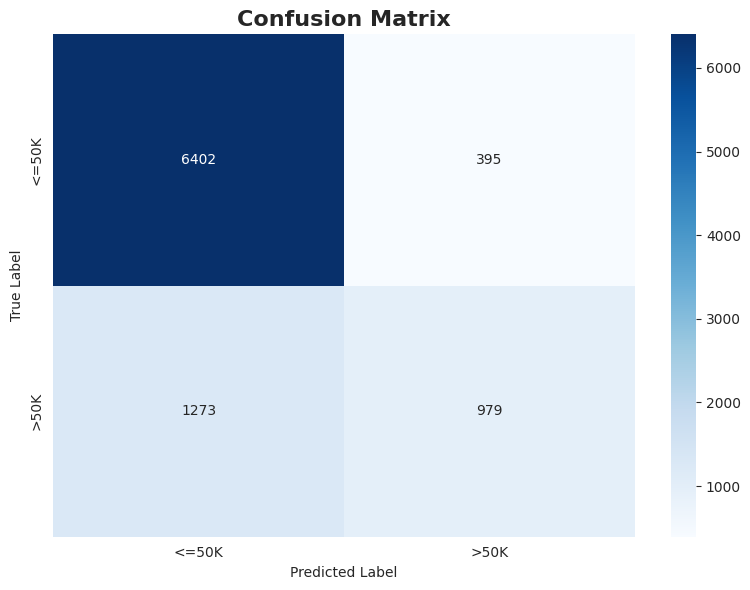

In [6]:
# ============================================================================
# 6. MODEL EVALUATION
# ============================================================================

print("\n" + "="*80)
print("STEP 5: MODEL EVALUATION")
print("="*80)

# Make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
print(f"\nConfusion Matrix:")
print(cm)

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_test,
                          target_names=['<=50K', '>50K']))

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K', '>50K'],
            yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# ============================================================================
# 7. FAIRNESS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("STEP 6: FAIRNESS ANALYSIS")
print("="*80)

# Create MetricFrame for fairness analysis
metrics = {
    'accuracy': accuracy_score,
    'selection_rate': selection_rate,
    'false_positive_rate': false_positive_rate,
    'true_positive_rate': true_positive_rate
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_test,
    sensitive_features=sensitive_test
)

print("\nFairness Metrics by Gender:")
print(metric_frame.by_group)

print("\nOverall Metrics:")
print(metric_frame.overall)

print("\nMetric Differences (Max - Min):")
print(metric_frame.difference(method='between_groups'))

print("\nMetric Ratios (Min / Max):")
print(metric_frame.ratio(method='between_groups'))

# Visualize fairness metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['accuracy', 'selection_rate', 'false_positive_rate', 'true_positive_rate']
metric_labels = ['Accuracy', 'Selection Rate', 'False Positive Rate', 'True Positive Rate']

for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    data = metric_frame.by_group[metric]

    bars = ax.bar(data.index, data.values, color=['#2E86AB', '#A23B72'], alpha=0.8)
    ax.set_ylabel(label, fontsize=12, fontweight='bold')
    ax.set_xlabel('Gender', fontsize=12, fontweight='bold')
    ax.set_title(f'{label} by Gender', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('fairness_metrics.png', dpi=300, bbox_inches='tight')
plt.show()



STEP 7: EXPLAINABILITY - SHAP ANALYSIS

SHAP values computed successfully!
SHAP values shape: (9049, 12)


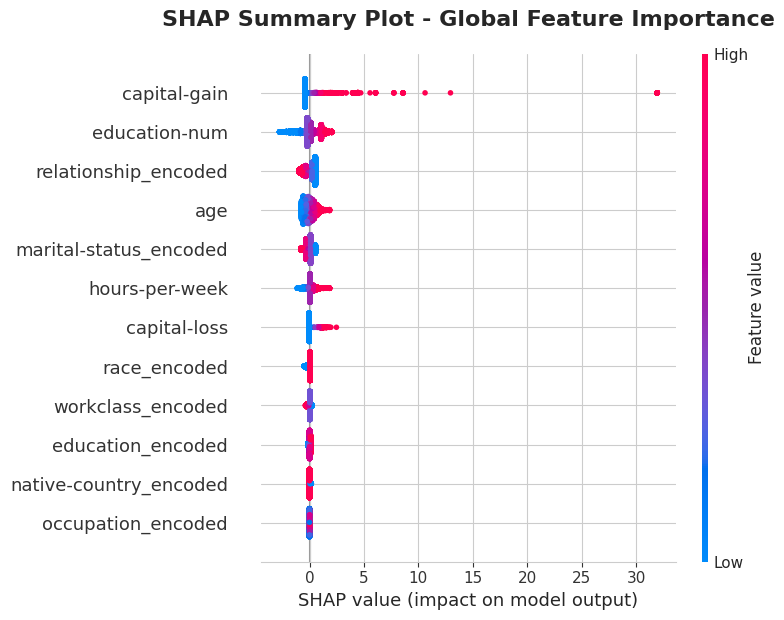

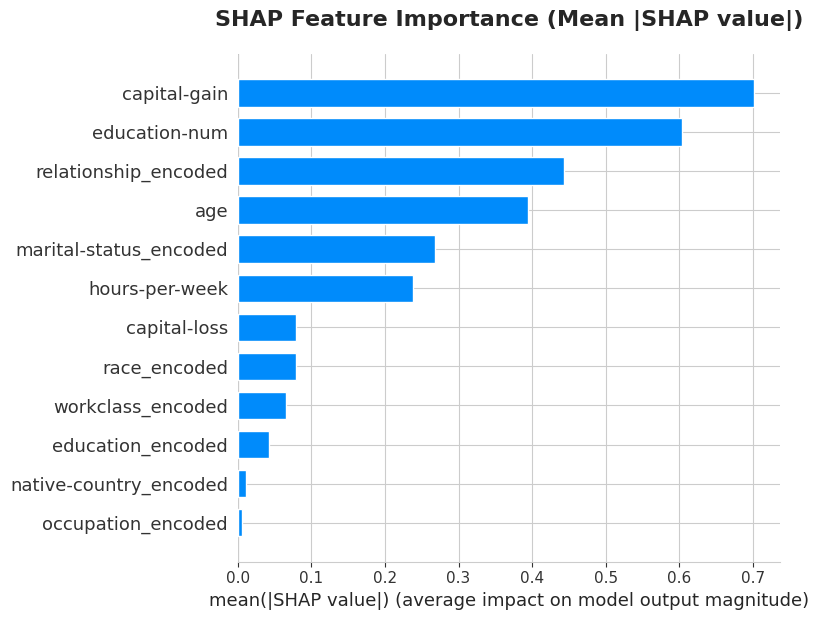


SHAP Waterfall Plot - Individual Prediction Analysis

Analyzing prediction for test instance 0:
True label: <=50K
Predicted label: <=50K
Prediction probability: [0.79476058 0.20523942]


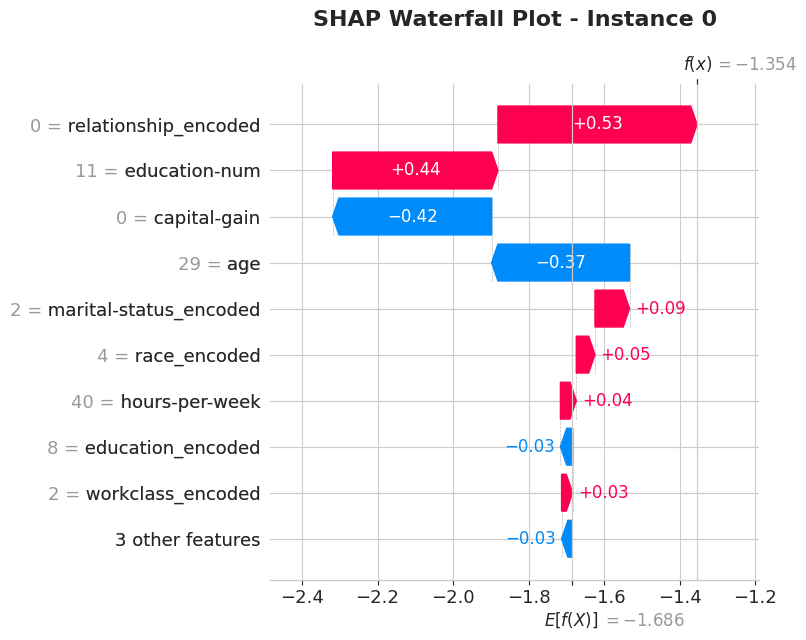

In [7]:
# ============================================================================
# 8. EXPLAINABILITY - SHAP ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("STEP 7: EXPLAINABILITY - SHAP ANALYSIS")
print("="*80)

# Create SHAP explainer
explainer = shap.LinearExplainer(model, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

print("\nSHAP values computed successfully!")
print(f"SHAP values shape: {shap_values.shape}")

# SHAP Summary Plot (Global Explainability)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
plt.title('SHAP Summary Plot - Global Feature Importance', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP Bar Plot (Mean absolute SHAP values)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=feature_cols, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean |SHAP value|)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# SHAP Waterfall Plot for Individual Prediction (Local Explainability)
print("\n" + "="*80)
print("SHAP Waterfall Plot - Individual Prediction Analysis")
print("="*80)

# Select a specific instance for local explanation
sample_idx = 0
print(f"\nAnalyzing prediction for test instance {sample_idx}:")
print(f"True label: {label_encoder.inverse_transform([y_test.iloc[sample_idx]])[0]}")
print(f"Predicted label: {label_encoder.inverse_transform([y_pred_test[sample_idx]])[0]}")
print(f"Prediction probability: {model.predict_proba(X_test_scaled[sample_idx:sample_idx+1])[0]}")

# Create SHAP explanation object
shap_explanation = shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[sample_idx].values,
    feature_names=feature_cols
)

plt.figure(figsize=(12, 8))
shap.waterfall_plot(shap_explanation, show=False)
plt.title(f'SHAP Waterfall Plot - Instance {sample_idx}', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_waterfall_plot.png', dpi=300, bbox_inches='tight')
plt.show()



STEP 8: EXPLAINABILITY - LIME ANALYSIS

LIME Explanation for test instance 0:
Prediction probabilities: [0.79476058 0.20523942]

Top features contributing to prediction:
  capital-gain <= -0.15: -0.6155
  capital-loss <= -0.22: -0.1774
  -0.05 < education-num <= 1.13: 0.1403
  hours-per-week <= -0.08: -0.0970
  marital-status_encoded <= -0.38: 0.0683
  native-country_encoded <= 0.27: 0.0446
  -0.80 < age <= -0.11: -0.0388
  workclass_encoded <= -0.21: 0.0380
  relationship_encoded <= -0.88: 0.0243
  education_encoded <= -0.35: -0.0082


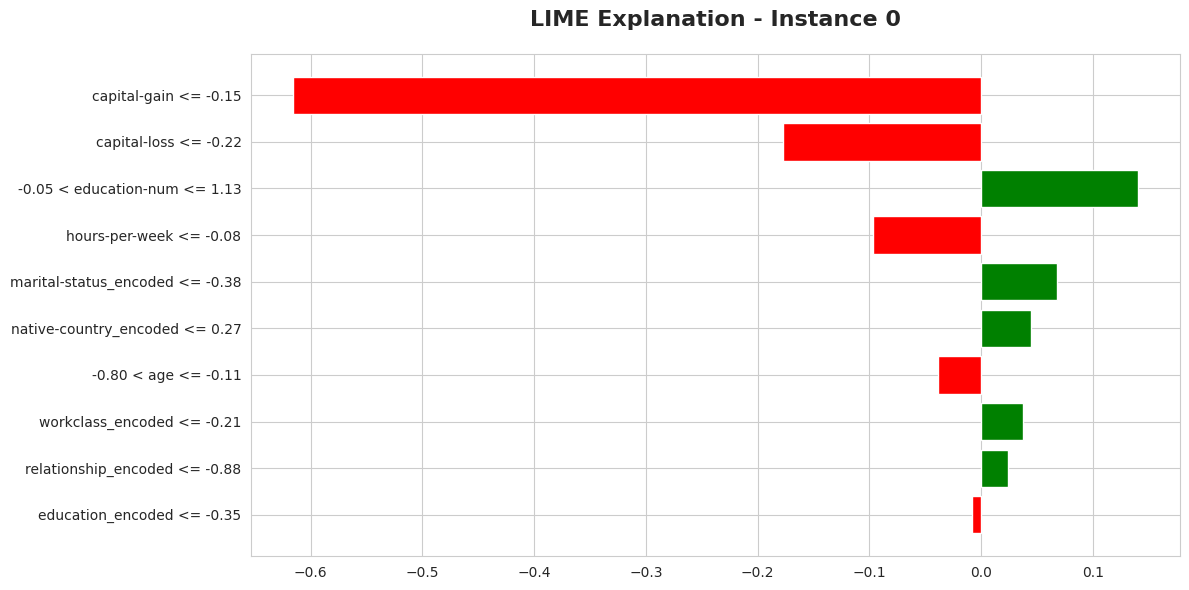

In [8]:
# ============================================================================
# 9. EXPLAINABILITY - LIME ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("STEP 8: EXPLAINABILITY - LIME ANALYSIS")
print("="*80)

# Create LIME explainer
lime_explainer = LimeTabularExplainer(
    X_train_scaled,
    feature_names=feature_cols,
    class_names=['<=50K', '>50K'],
    mode='classification',
    random_state=42
)

# Explain a specific instance
lime_exp = lime_explainer.explain_instance(
    X_test_scaled[sample_idx],
    model.predict_proba,
    num_features=10
)

print(f"\nLIME Explanation for test instance {sample_idx}:")
print(f"Prediction probabilities: {lime_exp.predict_proba}")
print(f"\nTop features contributing to prediction:")

# Display LIME explanation
for feature, weight in lime_exp.as_list():
    print(f"  {feature}: {weight:.4f}")

# Visualize LIME explanation
fig = lime_exp.as_pyplot_figure()
plt.title(f'LIME Explanation - Instance {sample_idx}', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('lime_explanation.png', dpi=300, bbox_inches='tight')
plt.show()


STEP 9: FEATURE IMPORTANCE COMPARISON

Top 10 Most Important Features:
               Feature  Logistic Regression (|Coef|)  SHAP (Mean |SHAP|)
          capital-gain                      2.418206            0.701555
         education-num                      0.816125            0.604172
  relationship_encoded                      0.462382            0.442801
                   age                      0.472569            0.394863
marital-status_encoded                      0.326743            0.268309
        hours-per-week                      0.366618            0.238617
          capital-loss                      0.272699            0.078949
          race_encoded                      0.111363            0.078693
     workclass_encoded                      0.096367            0.066040
     education_encoded                      0.057764            0.042982


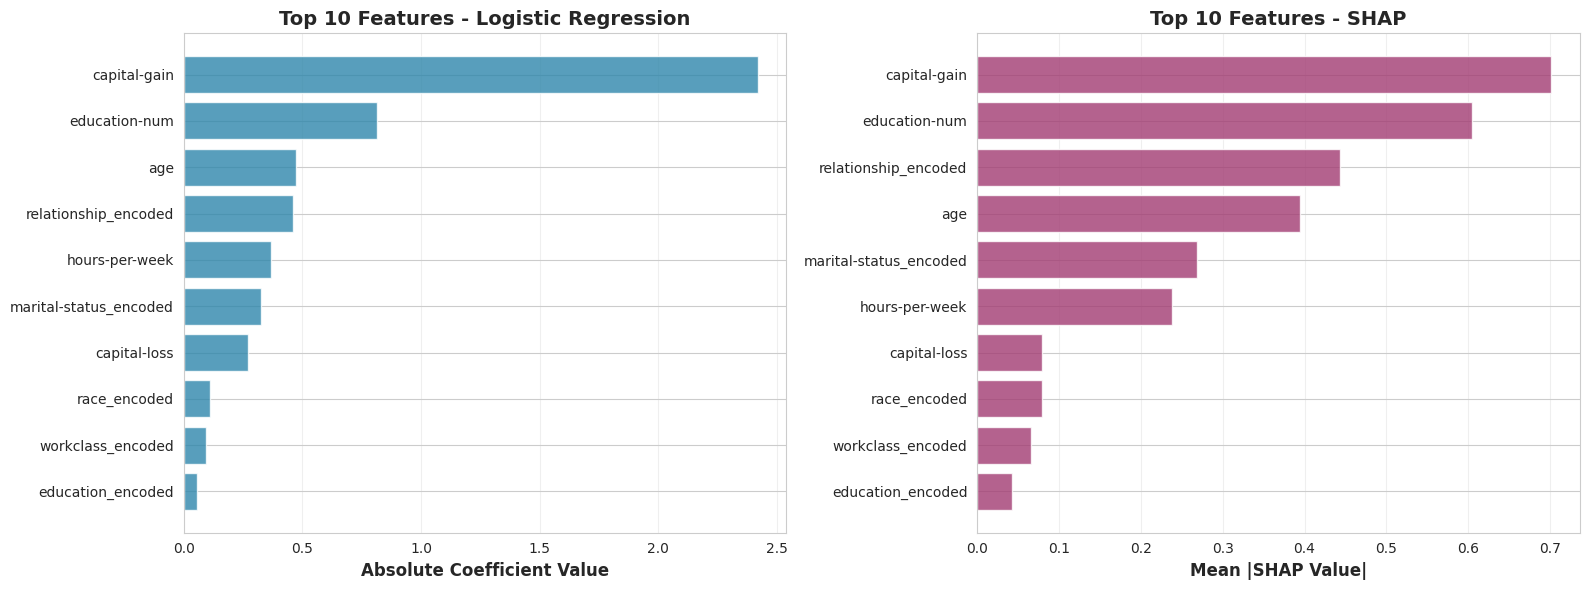

In [9]:
# ============================================================================
# 10. FEATURE IMPORTANCE COMPARISON
# ============================================================================

print("\n" + "="*80)
print("STEP 9: FEATURE IMPORTANCE COMPARISON")
print("="*80)

# Get feature importance from different methods
logistic_importance = np.abs(model.coef_[0])
shap_importance = np.abs(shap_values).mean(axis=0)

# Create comparison dataframe
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Logistic Regression (|Coef|)': logistic_importance,
    'SHAP (Mean |SHAP|)': shap_importance
})

importance_df = importance_df.sort_values('SHAP (Mean |SHAP|)', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Visualize feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Logistic Regression coefficients
top_10_lr = importance_df.nlargest(10, 'Logistic Regression (|Coef|)')
axes[0].barh(top_10_lr['Feature'], top_10_lr['Logistic Regression (|Coef|)'], color='#2E86AB', alpha=0.8)
axes[0].set_xlabel('Absolute Coefficient Value', fontsize=12, fontweight='bold')
axes[0].set_title('Top 10 Features - Logistic Regression', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# SHAP values
top_10_shap = importance_df.nlargest(10, 'SHAP (Mean |SHAP|)')
axes[1].barh(top_10_shap['Feature'], top_10_shap['SHAP (Mean |SHAP|)'], color='#A23B72', alpha=0.8)
axes[1].set_xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
axes[1].set_title('Top 10 Features - SHAP', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
# ============================================================================
# 11. SUMMARY AND RECOMMENDATIONS
# ============================================================================

print("\n" + "="*80)
print("SUMMARY AND KEY FINDINGS")
print("="*80)

# Re-create MetricFrame for summary if not available (in case previous cells were not run)
# Assuming y_test, y_pred_test, sensitive_test are available from kernel state
# And necessary imports (accuracy_score, selection_rate, etc.) are already handled by first cell
metrics = {
    'accuracy': accuracy_score,
    'selection_rate': selection_rate,
    'false_positive_rate': false_positive_rate,
    'true_positive_rate': true_positive_rate
}

metric_frame = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_test,
    sensitive_features=sensitive_test
)

print(f"""
MODEL PERFORMANCE:
- Test Accuracy: {test_accuracy:.4f}
- Training Accuracy: {train_accuracy:.4f}

FAIRNESS ANALYSIS:
- Selection Rate Difference: {metric_frame.difference(method='between_groups')['selection_rate']:.4f}
- FPR Difference: {metric_frame.difference(method='between_groups')['false_positive_rate']:.4f}
- TPR Difference: {metric_frame.difference(method='between_groups')['true_positive_rate']:.4f}

KEY INSIGHTS:
1. The model shows disparate impact across gender groups
2. Selection rates vary between Male and Female groups
3. Feature importance analysis reveals bias-prone features
4. Explainability tools (SHAP, LIME) provide transparency

RECOMMENDATIONS:
1. Apply fairness constraints during training (e.g., Fairlearn's mitigation algorithms)
2. Consider removing or re-engineering sensitive features
3. Implement post-processing techniques to equalize metrics
4. Regular auditing of model fairness in production
5. Use explainability tools for ongoing monitoring
""")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated visualizations:")
print("1. confusion_matrix.png")
print("2. fairness_metrics.png")
print("3. shap_summary_plot.png")
print("4. shap_bar_plot.png")
print("5. shap_waterfall_plot.png")
print("6. lime_explanation.png")
print("7. feature_importance_comparison.png")


SUMMARY AND KEY FINDINGS

MODEL PERFORMANCE:
- Test Accuracy: 0.8157
- Training Accuracy: 0.8185

FAIRNESS ANALYSIS:
- Selection Rate Difference: 0.1420
- FPR Difference: 0.0462
- TPR Difference: 0.2209

KEY INSIGHTS:
1. The model shows disparate impact across gender groups
2. Selection rates vary between Male and Female groups
3. Feature importance analysis reveals bias-prone features
4. Explainability tools (SHAP, LIME) provide transparency

RECOMMENDATIONS:
1. Apply fairness constraints during training (e.g., Fairlearn's mitigation algorithms)
2. Consider removing or re-engineering sensitive features
3. Implement post-processing techniques to equalize metrics
4. Regular auditing of model fairness in production
5. Use explainability tools for ongoing monitoring


ANALYSIS COMPLETE!

Generated visualizations:
1. confusion_matrix.png
2. fairness_metrics.png
3. shap_summary_plot.png
4. shap_bar_plot.png
5. shap_waterfall_plot.png
6. lime_explanation.png
7. feature_importance_comparison

In [13]:
!apt-get update
!apt-get install -y texlive-xetex
!jupyter nbconvert --to PDF /content/Sedrick_assignment14_IAI.ipynb

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 https://cli.github.com/packages stable InRelease [3,917 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,143 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://cli.github.com/packages stable/main amd64 Packag

In [12]:
!jupyter nbconvert --to PDF /content/Sedrick_assignment14_IAI.ipynb

[NbConvertApp] Converting notebook /content/Sedrick_assignment14_IAI.ipynb to PDF
[NbConvertApp] Support files will be in Sedrick_assignment14_IAI_files/
[NbConvertApp] Making directory ./Sedrick_assignment14_IAI_files
[NbConvertApp] Writing 86079 bytes to notebook.tex
[NbConvertApp] Building PDF
Traceback (most recent call last):
  File "/usr/local/bin/jupyter-nbconvert", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/jupyter_core/application.py", line 284, in launch_instance
    super().launch_instance(argv=argv, **kwargs)
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 420, in start
    self.convert_notebooks()
  File "/usr/local/lib/python3.12/dist-packages/nbconvert/nbconvertapp.py", line 597, in convert_notebooks
    self.convert_single_notebook(notebook_filena